In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [4]:
df = pd.read_csv('ReviewTokoBaju.csv')
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [9]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [10]:
# 2. Preprocessing - Data Cleaning
df.dropna(subset=['Review Text', 'Recommended IND'], inplace=True)

In [11]:
# Memilih fitur dan label
X = df['Review Text'].values
y = df['Recommended IND'].values

In [12]:
# Label Encoding untuk target column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [13]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Tokenization and padding using Keras (for TensorFlow model)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100  # Max sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [16]:
# Convert labels to tensor for PyTorch
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

In [31]:
# 3. PyTorch Model (RNN)
class RNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)  # yang ini yang diubah
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # We take the output of the last time step
        return self.sigmoid(out)

In [22]:
# Hyperparameters for RNN Model
input_dim = 5000  # Number of unique words in the vocabulary (from tokenizer)
embedding_dim = 128  # Dimension of the embedding layer
hidden_size = 128  # Number of hidden units in RNN
output_size = 1  # Binary classification
model = RNNModel(input_dim, embedding_dim, hidden_size, output_size)

In [23]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Training loop for PyTorch
num_epochs = 10
train_loss = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Convert data to tensor (saat training) # yang ini yang diubah
    inputs = torch.tensor(X_train_pad, dtype=torch.long)  # Pastikan menggunakan torch.long
    targets = y_train_tensor.float().view(-1, 1)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.4611
Epoch [2/10], Loss: 0.4638
Epoch [3/10], Loss: 0.4670
Epoch [4/10], Loss: 0.4625
Epoch [5/10], Loss: 0.4521
Epoch [6/10], Loss: 0.4414
Epoch [7/10], Loss: 0.4342
Epoch [8/10], Loss: 0.4315
Epoch [9/10], Loss: 0.4314
Epoch [10/10], Loss: 0.4315


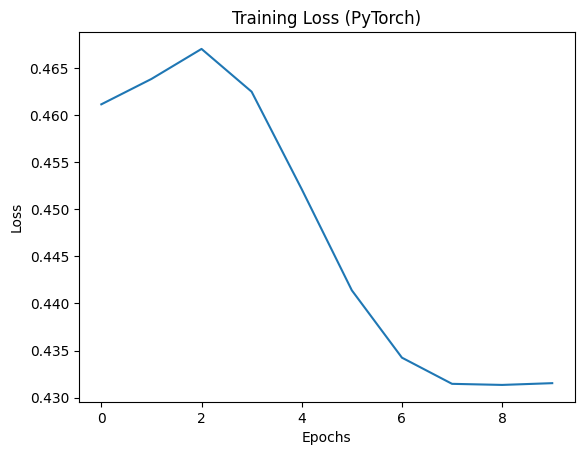

In [33]:
# Plot loss
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss (PyTorch)')
plt.show()

In [38]:
# 4. TensorFlow Model (RNN)
model_tf = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
# Train the TensorFlow model
history = model_tf.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8194 - loss: 0.4481 - val_accuracy: 0.8432 - val_loss: 0.3748
Epoch 2/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8487 - loss: 0.3591 - val_accuracy: 0.8404 - val_loss: 0.3749
Epoch 3/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8640 - loss: 0.3146 - val_accuracy: 0.8406 - val_loss: 0.3393
Epoch 4/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8908 - loss: 0.2687 - val_accuracy: 0.8598 - val_loss: 0.3625
Epoch 5/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9098 - loss: 0.2220 - val_accuracy: 0.8688 - val_loss: 0.3315
Epoch 6/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9162 - loss: 0.2165 - val_accuracy: 0.8563 - val_loss: 0.3718
Epoch 7/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9104 - loss: 0.2332 - val_accuracy: 0.8457 - val_loss: 0.4342
Epoch 8/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9260 - loss: 0.1909 - val_accu

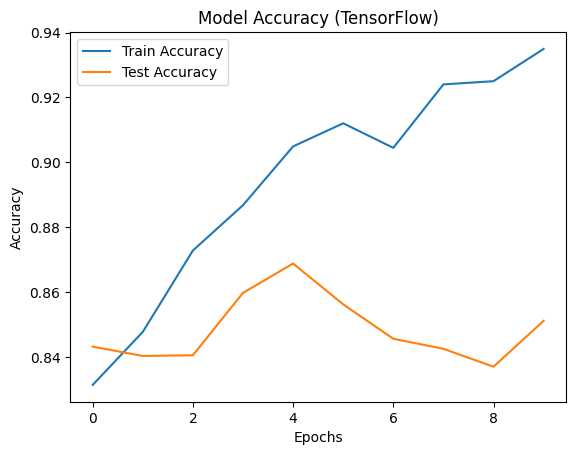

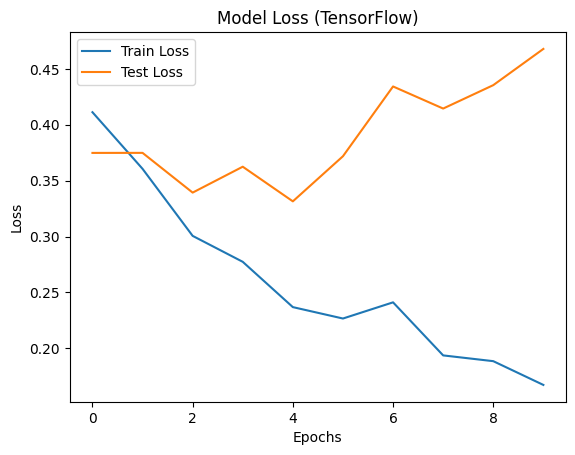

In [40]:
# Plot training & validation accuracy and loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy (TensorFlow)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss (TensorFlow)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
# 5. Evaluate Models

# PyTorch Evaluation
model.eval()
with torch.no_grad():
    test_inputs = torch.tensor(X_test_pad, dtype=torch.long)  # Pastikan menggunakan torch.long # yang ini yang diubah
    test_outputs = model(test_inputs)
    test_predictions = test_outputs.round().view(-1).numpy()

In [42]:
# Compute Metrics for PyTorch Model
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_predictions)
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)

print(f"Accuracy (PyTorch): {accuracy:.4f}")
print(f"Precision (PyTorch): {precision:.4f}")
print(f"Recall (PyTorch): {recall:.4f}")
print(f"F1-Score (PyTorch): {f1:.4f}")
print(f"AUC (PyTorch): {roc_auc:.4f}")

Accuracy (PyTorch): 0.8260
Precision (PyTorch): 0.8408
Recall (PyTorch): 0.9720
F1-Score (PyTorch): 0.9017
AUC (PyTorch): 0.5648


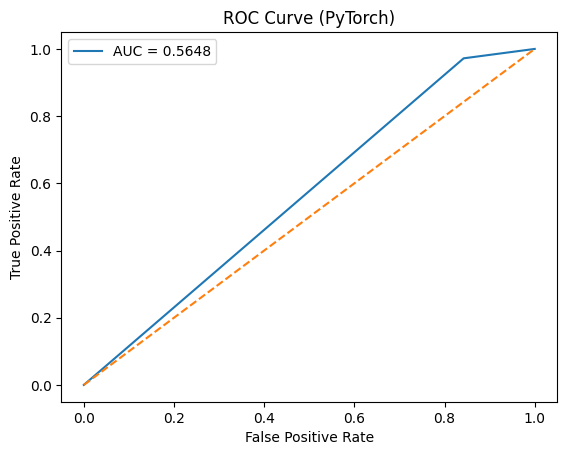

In [43]:
# Plot ROC curve for PyTorch
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve (PyTorch)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [44]:
# TensorFlow Evaluation
test_loss, test_acc = model_tf.evaluate(X_test_pad, y_test)
print(f"Test Accuracy (TensorFlow): {test_acc:.4f}")

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8339 - loss: 0.5301
Test Accuracy (TensorFlow): 0.8512


In [45]:
# Predict using TensorFlow model
y_pred_tf = (model_tf.predict(X_test_pad) > 0.5).astype(int)

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [46]:
# Compute metrics for TensorFlow model
accuracy_tf = accuracy_score(y_test, y_pred_tf)
precision_tf = precision_score(y_test, y_pred_tf)
recall_tf = recall_score(y_test, y_pred_tf)
f1_tf = f1_score(y_test, y_pred_tf)
roc_auc_tf = roc_auc_score(y_test, y_pred_tf)
fpr_tf, tpr_tf, thresholds_tf = roc_curve(y_test, y_pred_tf)

print(f"Accuracy (TensorFlow): {accuracy_tf:.4f}")
print(f"Precision (TensorFlow): {precision_tf:.4f}")
print(f"Recall (TensorFlow): {recall_tf:.4f}")
print(f"F1-Score (TensorFlow): {f1_tf:.4f}")
print(f"AUC (TensorFlow): {roc_auc_tf:.4f}")

Accuracy (TensorFlow): 0.8512
Precision (TensorFlow): 0.8988
Recall (TensorFlow): 0.9225
F1-Score (TensorFlow): 0.9105
AUC (TensorFlow): 0.7236


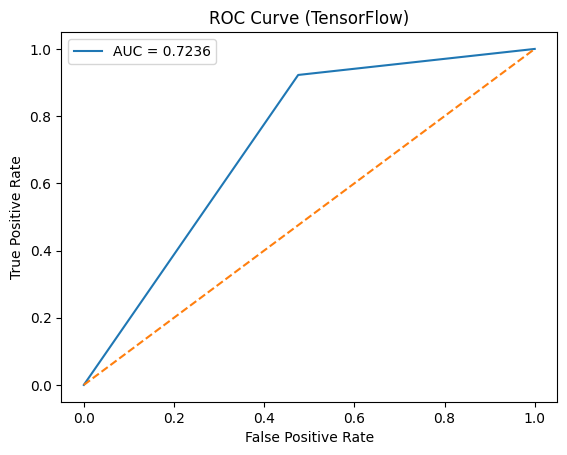

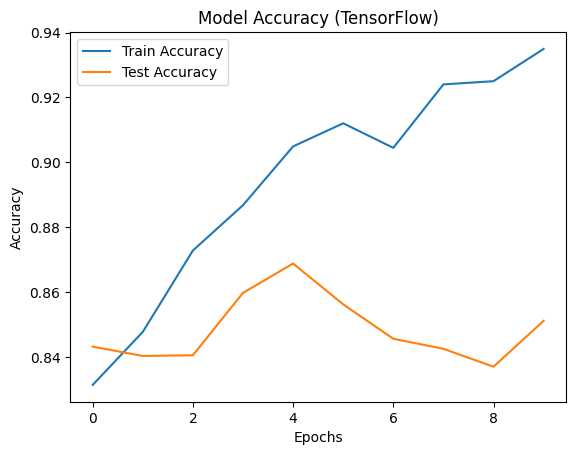

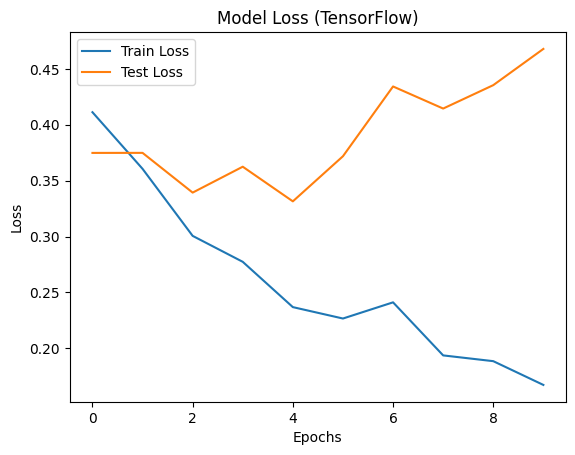

In [47]:
# Plot ROC curve for TensorFlow model
plt.plot(fpr_tf, tpr_tf, label=f'AUC = {roc_auc_tf:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve (TensorFlow)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Visualizing the Accuracy and Loss for TensorFlow
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy (TensorFlow)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss (TensorFlow)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 1. **Deskripsi Proyek**
Proyek ini bertujuan untuk mengklasifikasikan ulasan produk dalam dataset `ReviewTokoBaju.csv` menggunakan model Recurrent Neural Network (RNN). Data yang digunakan berisi teks ulasan dan label biner yang mengindikasikan apakah produk tersebut direkomendasikan atau tidak. Model RNN dibangun dan diuji menggunakan dua framework deep learning: PyTorch dan TensorFlow.

Proyek ini melibatkan beberapa langkah penting:
- Preprocessing Data: Tokenisasi dan padding dilakukan untuk mempersiapkan data teks untuk model.
- Membangun dan Melatih Model: Model RNN dibangun di kedua framework dan dilatih menggunakan data pelatihan.
- Evaluasi Model: Model dievaluasi menggunakan beberapa metrik kinerja seperti Accuracy, Precision, Recall, F1-Score, AUC, dan ROC Curve.
- Visualisasi: Grafik akurasi dan loss ditampilkan untuk memonitor performa model selama pelatihan.

### 2. **Hasil Evaluasi Model**

#### **Hasil Evaluasi pada PyTorch**:
- **Accuracy (PyTorch)**: 0.8260
  - Ini menunjukkan bahwa model PyTorch berhasil mengklasifikasikan dengan benar sekitar 82.60% dari data uji.
  
- **Precision (PyTorch)**: 0.8408
  - Precision mengukur seberapa tepat model dalam memprediksi kelas positif (direkomendasikan). Dengan precision 0.8408, model memiliki tingkat ketepatan 84.08% dalam memprediksi ulasan yang benar-benar positif.
  
- **Recall (PyTorch)**: 0.9720
  - Recall mengukur seberapa baik model dalam mendeteksi seluruh contoh positif yang ada. Nilai recall yang tinggi, 97.20%, berarti model sangat baik dalam mendeteksi ulasan yang benar-benar direkomendasikan.
  
- **F1-Score (PyTorch)**: 0.9017
  - F1-Score adalah rata-rata harmonis antara precision dan recall, memberikan gambaran seimbang antara keduanya. Dengan F1-Score 0.9017, model PyTorch memiliki keseimbangan yang baik antara precision dan recall.
  
- **AUC (PyTorch)**: 0.5648
  - AUC (Area Under the Curve) mengukur performa model dalam membedakan kelas positif dan negatif. Nilai AUC 0.5648 menunjukkan bahwa model PyTorch memiliki kemampuan yang cukup terbatas dalam membedakan kedua kelas, meskipun recall-nya sangat tinggi.

#### **Hasil Evaluasi pada TensorFlow**:
- **Accuracy (TensorFlow)**: 0.8512
  - Model TensorFlow mencapai akurasi 85.12% pada data uji, yang sedikit lebih tinggi dari model PyTorch, menunjukkan bahwa model ini lebih efektif dalam klasifikasi secara keseluruhan.

- **Precision (TensorFlow)**: 0.8988
  - Dengan precision 89.88%, model TensorFlow memiliki ketepatan yang sangat baik dalam mengidentifikasi ulasan yang benar-benar positif.

- **Recall (TensorFlow)**: 0.9225
  - Recall 92.25% menunjukkan bahwa model TensorFlow dapat menangkap sebagian besar ulasan yang direkomendasikan, meskipun tidak sebaik model PyTorch.

- **F1-Score (TensorFlow)**: 0.9105
  - F1-Score yang sedikit lebih tinggi di 91.05% menunjukkan bahwa model TensorFlow memiliki keseimbangan yang baik antara precision dan recall, bahkan lebih baik dibandingkan dengan model PyTorch.

- **AUC (TensorFlow)**: 0.7236
  - AUC yang lebih tinggi (72.36%) menunjukkan bahwa model TensorFlow lebih baik dalam membedakan antara ulasan yang direkomendasikan dan yang tidak, dibandingkan dengan model PyTorch.

### 3. **Penjelasan Metrik Evaluasi**

#### **Accuracy**
- Definisi: Proporsi prediksi yang benar dari total prediksi yang dibuat.
- **Rumus**:


$$\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}}$$

  
  Accuracy memberikan gambaran umum dari kinerja model, namun kurang sensitif terhadap ketidakseimbangan kelas.

#### **Precision**
- Definisi: Proporsi prediksi positif yang benar di antara semua prediksi positif yang dibuat oleh model.
- **Rumus**:
  
  $$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$

  
  Precision menunjukkan berapa banyak dari ulasan yang diprediksi sebagai positif yang benar-benar positif.

#### **Recall**
- Definisi: Proporsi contoh positif yang benar-benar terdeteksi oleh model.
- **Rumus**:
  
  $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$

  
  Recall menunjukkan kemampuan model untuk menangkap ulasan yang benar-benar positif.

#### **F1-Score**
- Definisi: Harmonic mean dari precision dan recall, memberikan gambaran seimbang tentang kinerja model.
- **Rumus**:
  
  $$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

  
  F1-Score digunakan ketika Anda membutuhkan keseimbangan antara precision dan recall, dan berguna untuk mengukur model dengan dataset yang tidak seimbang.

#### **AUC (Area Under the Curve)**
- Definisi: Area di bawah kurva ROC (Receiver Operating Characteristic), yang menggambarkan kemampuan model untuk membedakan antara kelas positif dan negatif.
- **Rumus**: Tidak ada rumus eksplisit karena AUC dihitung dari kurva ROC. Nilai AUC berkisar antara 0 hingga 1:
  - AUC = 0.5 berarti model tidak dapat membedakan antara kelas positif dan negatif (model acak).
  - AUC = 1 berarti model sempurna dalam membedakan kelas positif dan negatif.

#### **ROC Curve (Receiver Operating Characteristic)**
- Definisi: Grafik yang menunjukkan trade-off antara true positive rate (recall) dan false positive rate (1-specificity) pada berbagai threshold.
- Fungsi: Menyediakan gambaran seimbang tentang kinerja model di berbagai ambang batas prediksi.

### 4. **Penjelasan Persamaan Matematika yang Ada**

- **RNN Formula** (untuk Forward Pass):
  
  $$h_t = \tanh(W_h \cdot x_t + U_h \cdot h_{t-1} + b_h)$$\\
  
  Di mana:
  - $ h_t $ adalah hidden state pada waktu $ t $,
  - $ x_t $ adalah input pada waktu $ t $ ,
  - $ W_h , U_h ,$ dan $b_h$ adalah parameter yang dipelajari oleh model,
  - $ tanh $ adalah fungsi aktivasi yang digunakan untuk menghasilkan output hidden state yang terjaga antara -1 dan 1.

- **Loss Function**:
  
  $$L = - \frac{1}{N} \sum_{i=1}^{N} [y_i \log(p_i) + (1 - y_i) \log(1 - p_i)]$$
  
  Di mana:
  - $ L $ adalah fungsi kerugian (loss),
  - $ y_i $ adalah label target yang sebenarnya,
  - $ p_i $ adalah probabilitas prediksi untuk kelas positif,
  - $ N $ adalah jumlah total sampel.

### 5. **Kesimpulan**

| **Metrik**     | **Nilai (PyTorch)** | **Nilai (TensorFlow)** |
|----------------|---------------------|------------------------|
| **Accuracy**   | 0.8260              | 0.8512                 |
| **Precision**  | 0.8408              | 0.8988                 |
| **Recall**     | 0.9720              | 0.9225                 |
| **F1 Score**   | 0.9017              | 0.9105                 |
| **AUC**        | 0.5648              | 0.7236                 |


- Model TensorFlow menunjukkan performa yang sedikit lebih baik dalam hal Accuracy, Precision, Recall, dan AUC dibandingkan dengan model PyTorch.
- PyTorch memiliki recall yang lebih tinggi, namun AUC dan precision yang lebih rendah dibandingkan TensorFlow.
- AUC untuk PyTorch menunjukkan bahwa model ini kurang efektif dalam membedakan antara kelas positif dan negatif, meskipun recall sangat tinggi. Sedangkan model TensorFlow memiliki AUC yang lebih baik, menunjukkan kemampuannya yang lebih baik dalam membedakan kelas.

Dengan metrik yang diperoleh dan evaluasi ini, kbisa disimpulkan bahwa TensorFlow lebih efektif dalam tugas klasifikasi ini, meskipun PyTorch memberikan hasil yang juga cukup baik dalam beberapa aspek seperti recall.